# 日本国債損益モニタリング

## 概要

日本国債の時価を計算し，各基準日の損益をExcelで集計するツールである．

財務省が公表している日本国債（以下，単に国債）の入札結果をもとに，2024年4月から2025年3月までの月次で仮想の国債ポジション明細を作成する．明細には国債の新規購入・中途売却・満期償還も含む．

次に財務省が日次で公表している国債の最終利回りから，**QuantLib-Python**のFixedRateBondHelperクラスを用いて割引カーブを引く．この時，元データの最終利回りについて以下を仮定する：

- 各年限グリッドごとに選定する代表銘柄はパー価格である，
    - ３年の最終利回りを計算する際に用いる残存3年の5年債の価格が100円である，
- 半年複利ベースの最終利回りを上記パー債の半年単利クーポンレートで近似できる．

ポシションを割引いて時価と修正デュレーションを計算し，明細に追加してcsvファイルとして出力する．

時価情報が追加された明細をExcelのPower Query機能で取り込み評価損益を計算し，Power Pivot機能でテーブルに集計する．テーブルには以下の項目を載せ，期初・期末をライムラインで指定できる形とする．

|項目|記号|
|---|:---:|
| 銘柄名 | - |
| 利率 | - |
| 簿価残高 | A |
| 評価損益 | B |
| 評価損益（期末-期初） | C |
| 実現損益 | D |
| 総合損益 | C+D |
| 評価損益（期初） | B-C+D |
| 修正デュレーション | E |
| 金利変化（換算） | (C+D)/A/E |

## 実装

### ライブラリインポート

In [52]:
import re #和暦→西暦変換用

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import QuantLib as ql

### 仮想の国債ポジション明細データの読み込み

In [53]:
historical_meisai = pd.read_csv('Input//日本国債明細.csv')
historical_meisai['基準日'] = pd.to_datetime(historical_meisai['基準日'], format='%Y/%m/%d')
historical_meisai['発行日'] = pd.to_datetime(historical_meisai['発行日'], format='%Y/%m/%d')
historical_meisai['償還日'] = pd.to_datetime(historical_meisai['償還日'], format='%Y/%m/%d')
historical_meisai.set_index(['基準日', '銘柄'], inplace=True)

# 基準日のリストの抽出
eval_dates = historical_meisai.index.get_level_values('基準日').unique()

display(historical_meisai)

発行日        償還日       利率           簿価
基準日        銘柄                                                          
2024-04-30 第448回利付国庫債券（2年）  2023-05-01 2025-05-01  0.00042    300000000
           第142回利付国庫債券（5年）  2020-03-11 2024-12-20 -0.00220   6000000000
           第153回利付国庫債券（5年）  2022-09-14 2027-06-20  0.00040  10000000000
           第335回利付国庫債券（10年） 2014-09-22 2024-09-20  0.00517   1000000000
           第347回利付国庫債券（10年） 2017-08-03 2027-06-20  0.00073   5000000000
...                                ...        ...      ...          ...
2025-03-31 第153回利付国庫債券（5年）  2022-09-14 2027-06-20  0.00040  10000000000
           第169回利付国庫債券（5年）  2024-06-21 2029-03-20  0.00512   1400000000
           第170回利付国庫債券（5年）  2024-07-10 2029-06-20  0.00612    500000000
           第347回利付国庫債券（10年） 2017-08-03 2027-06-20  0.00073   5000000000
           第375回利付国庫債券（10年） 2024-09-04 2034-06-20  0.00915   1000000000

[97 rows x 4 columns]

### 日本国債コンベンションの定義

In [54]:
tenor = ql.Period(ql.Semiannual)     # 利払間隔
calendar = ql.Japan()                # 休祝日カレンダー
convention = ql.ModifiedFollowing    # 営業日調整
day_count = ql.Thirty360(convention) # 日数計算
rule = ql.DateGeneration.Backward    # 日付生成のルール
end_of_month = False                 # 月末日ロール
settlemant_days = 1                  # 決済日数

### 和暦を西暦に変換する関数の定義

In [55]:
def convert_japanese_era_to_gregorian(date_str: str) -> str | None:
    """和暦の日付を西暦に変換する関数"""
    
    # 元号と対応する西暦の開始年
    era_map: dict[str, int] = {
        "S": 1925,  # 昭和1年は1926年
        "H": 1988,  # 平成1年は1989年
        "R": 2018   # 令和1年は2019年
    }

    # 正規表現で元号・年・月・日を抽出
    match: re.Match | None = re.match(r"(S|H|R)(\d+)\.(\d+)\.(\d+)", date_str)
    
    if match:
        era: str
        year: int
        month: int
        day: int
        
        era, year_str, month_str, day_str = match.groups()
        year = int(year_str)
        month = int(month_str)
        day = int(day_str)

        # 西暦の計算
        gregorian_year: int = era_map[era] + year
        
        return f"{gregorian_year}.{month}.{day}"
    
    return None  # 変換できない場合

### 年限別の最終利回りデータの読み込み

In [56]:
historical_ytms = pd.read_csv('Input//jgbcm_all.csv', encoding='shift-jis', header=1)
historical_ytms['基準日'] = historical_ytms['基準日'].apply(convert_japanese_era_to_gregorian)
historical_ytms['基準日'] = pd.to_datetime(historical_ytms['基準日'], format='%Y.%m.%d')
historical_ytms.set_index('基準日', inplace=True)

display(historical_ytms)

,1年,2年,3年,4年,5年,6年,7年,8年,9年,10年,15年,20年,25年,30年,40年
基準日,,,,,,,,,,,,,,,
1974-09-24,10.327,9.362,8.83,8.515,8.348,8.290,8.240,8.121,8.127,-,-,-,-,-,-
1974-09-25,10.333,9.364,8.831,8.516,8.348,8.290,8.240,8.121,8.127,-,-,-,-,-,-
1974-09-26,10.34,9.366,8.832,8.516,8.348,8.290,8.240,8.122,8.128,-,-,-,-,-,-
1974-09-27,10.347,9.367,8.833,8.517,8.349,8.290,8.240,8.122,8.128,-,-,-,-,-,-
1974-09-28,10.354,9.369,8.834,8.518,8.349,8.291,8.240,8.122,8.129,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,0.554,0.728,0.808,0.927,1.023,1.075,1.151,1.264,1.395,1.522,2.136,2.498,2.758,2.9,3.24
2025-05-27,0.566,0.739,0.811,0.922,1.012,1.057,1.117,1.229,1.357,1.479,2.035,2.354,2.613,2.743,3.062
2025-05-28,0.575,0.753,0.83,0.955,1.054,1.108,1.179,1.286,1.409,1.531,2.077,2.406,2.656,2.796,3.107


### 各基準日で最終利回りから割引カーブを引いて時価を計算

In [57]:
list_meisai = []

for eval_date in eval_dates:

    # 基準日の最終利回りを取得
    rates = historical_ytms.loc[eval_date]
    dict_rates = rates.to_dict()
    dict_rates = {int(k[:-1]): np.float64(v) for k, v in rates.items()} # 年限を整数に変換し、値をfloat64に変換

    # QuantLibに基準日を設定
    eval_date_ql = ql.Date.from_date(eval_date)
    ql.Settings.instance().evaluationDate = eval_date_ql

    helpers = []
    for tenor, rate in dict_rates.items():
        
        # 代表銘柄のCFスケジュールを作成
        schedule = ql.Schedule(
            eval_date_ql,
            calendar.adjust(eval_date_ql + ql.Period(tenor, ql.Years), convention),
            ql.Period(ql.Semiannual),  # 支払頻度（半年ごと）
            calendar,  # カレンダー（例：ql.Japan()）
            convention,  # 調整規則（例：ql.Following）
            convention,  # 終了日の調整規則
            rule,  # 日付生成ルール
            end_of_month  # 月末調整
            )

        price = 100. # 代表銘柄についてパー価格を仮定
        price_quote = ql.SimpleQuote(price)
        price_handle = ql.QuoteHandle(price_quote)
        
        # 債券ヘルパーの作成
        helper = ql.FixedRateBondHelper(
            price_handle,    # 債券価格
            settlemant_days, # 決済日数
            100.0,           # 額面
            schedule,        # 債券のスケジュール
            [rate / 100],    # クーポン率
            day_count,       # 日数計算方法
        )
        helpers.append(helper)
    
    # 割引カーブの構築
    discount_curve = ql.PiecewiseLogLinearDiscount(eval_date_ql, helpers, day_count)
    discount_handle = ql.YieldTermStructureHandle(discount_curve)
    engine = ql.DiscountingBondEngine(discount_handle)

    meisai = historical_meisai.loc[eval_date].copy()
    # 各銘柄の時価と修正デュレーションを計算
    for _ in range(len(meisai)):
        meigara = meisai.iloc[_]
        
        # 保有債券のCFスケジュールを作成
        schedule = ql.Schedule(
            ql.Date.from_date(meigara['発行日']),
            ql.Date.from_date(meigara['償還日']),
            ql.Period(ql.Semiannual),
            calendar,
            convention,
            convention,
            rule,
            end_of_month
            )

        # 保有債券の固定利付債券オブジェクトを作成
        bond = ql.FixedRateBond(
                settlemant_days,
                np.float64(meigara['簿価']),         
                schedule,
                [meigara['利率']],
                day_count
            )
        bond.setPricingEngine(engine)            
        meisai.loc[meisai.index[_], '時価'] = bond.NPV()
        
        # 簿価が0の場合は修正デュレーションを0に設定
        if bond.notional() == 0:
            meisai.loc[meisai.index[_], '修正デュレーション'] = 0.0
        else:
           # 経過利息を除いた価格の計算
            clean_price = ql.BondPrice(bond.cleanPrice(), ql.BondPrice.Clean)

            # 最終利回りの計算
            ytm = bond.bondYield(
                clean_price,
                day_count,
                ql.Compounded, 
                ql.Semiannual
            )
            # 金利オブジェクトの作成
            interest_rate = ql.InterestRate(
                ytm,
                day_count,
                ql.Compounded,
                ql.Semiannual
            )
            # 修正デュレーションの計算
            duration = ql.BondFunctions.duration(
                bond,
                interest_rate,
                ql.Duration.Modified
            )
            meisai.loc[meisai.index[_], '修正デュレーション'] = duration

    meisai['基準日'] = eval_date
    meisai.set_index('基準日', append=True, inplace=True)
    meisai = meisai.swaplevel(0, 1)
    list_meisai.append(meisai)

参考までに2025年3月31日時点の日本国債の割引カーブをプロットした．

,Date,Discount
0,2025-03-31,1.000000
1,2026-03-31,0.993631
2,2027-03-31,0.983089
3,2028-03-31,0.973778
4,2029-03-30,0.960061
5,2030-03-29,0.945841
6,2031-03-31,0.933645
7,2032-03-31,0.919396
8,2033-03-31,0.901747
9,2034-03-31,0.881478


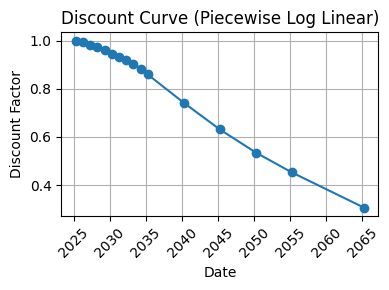

In [58]:
dates = discount_curve.dates()
discounts = [discount_curve.discount(date) for date in dates]
date_labels = [date.to_date() for date in dates]

df = pd.DataFrame({
    "Date": date_labels,
    "Discount": discounts
})
display(df)

plt.figure(figsize=(4, 3))
plt.plot(df["Date"], df["Discount"], marker='o', linestyle='-')
plt.title("Discount Curve (Piecewise Log Linear)")
plt.xlabel("Date")
plt.ylabel("Discount Factor")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ファイルの出力

In [59]:
pd.concat(list_meisai).to_csv('Output//国内債券明細_時価評価.csv', encoding='utf-8')